In [8]:
!pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 21.7 MB/s eta 0:00:00a 0:00:01
  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00a 0:00:01


In [9]:
import os
#import pydicom
#from pydicom.misc import is_dicom
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

In [ ]:
def load_dicom_images(directory, max_slices=None):
    slices = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".dcm"):
            path = os.path.join(directory, filename)
            dicom = pydicom.dcmread(path)
            slices.append(dicom)
            if max_slices and len(slices) >= max_slices:
                break
    # Ordenar as fatias por posição do paciente
    slices.sort(key=lambda x: x.ImagePositionPatient[2])
    return slices

def create_3d_image(slices):
    # Extrair arrays de pixel e empilhá-los
    pixel_arrays = [s.pixel_array for s in slices]
    image_3d = np.stack(pixel_arrays, axis=-1)
    # Converter para imagem ITK
    itk_image = sitk.GetImageFromArray(image_3d)
    return itk_image

def show_slices(image_array, num_slices=165, cols=11):
    # Calcular número de linhas necessárias
    rows = num_slices // cols + (num_slices % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

    for i in range(num_slices):
        row = i // cols
        col = i % cols
        axes[row, col].imshow(image_array[:, :, i], cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Slice {i}')

    # Remover subplots extras se o número de fatias for menor que o grid total
    for j in range(num_slices, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

def correct_orientation(itk_image):
    # Obter a matriz de transformação atual
    origin = itk_image.GetOrigin()
    direction = itk_image.GetDirection()
    spacing = itk_image.GetSpacing()
    
    # Alterar a direção da imagem para que os eixos estejam orientados corretamente
    # Isso depende da orientação específica dos dados DICOM
    direction_corrected = [1, 0, 0, 0, 1, 0, 0, 0, -1]  # Exemplo para inverter o eixo Z
    
    itk_image.SetDirection(direction_corrected)
    
    # Atualizar a origem da imagem se necessário
    # Exemplo: modificar a origem para compensar a mudança na orientação
    origin_corrected = (origin[0], origin[1], origin[2] + (len(slices) - 1) * spacing[2])
    itk_image.SetOrigin(origin_corrected)
    
    return itk_image

# Caminho p DICOM
dicom_directory = "C:/Users/bruno/Desktop/IANS/mri_exemplo/DICOM/I60175"

# Carregar  DICOM
slices = load_dicom_images(dicom_directory, max_slices=166)  # Limitar a 166 imagens
image_3d = create_3d_image(slices)

# Corrigir a orientação da imagem
image_3d_corrected = correct_orientation(image_3d)

# Converter a imagem segmentada para um array NumPy para visualização
img_array = sitk.GetArrayFromImage(image_3d_corrected)

# Visualizar os cortes 2D da imagem segmentada (somente o cérebro)
show_slices(img_array, num_slices=166, cols=11)

# Salvar a imagem 3D segmentada como um arquivo NIfTI
sitk.WriteImage(image_3d, "C:/Users/bruno/Desktop/IANS/mri_exemplo/NIFTL/output_brain_2_oriented.nii.gz")

In [10]:
def print_image(image):

    # Converte a imagem para um numpy array
    image_array = image.numpy()

    # Obtém o índice central para cada dimensão
    axial_index = image_array.shape[0] // 2  # Corte axial
    coronal_index = image_array.shape[1] // 2  # Corte coronal
    sagital_index = image_array.shape[2] // 2  # Corte sagital

    # Cria um gráfico com 3 subgráficos
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Exibe o corte axial
    axes[0].imshow(image_array[:, :, axial_index], cmap='gray')
    axes[0].set_title('Corte Axial')
    axes[0].axis('off')

    # Exibe o corte coronal
    axes[1].imshow(image_array[:, coronal_index, :], cmap='gray')
    axes[1].set_title('Corte Coronal')
    axes[1].axis('off')

    # Exibe o corte sagital
    axes[2].imshow(image_array[sagital_index, :, :], cmap='gray')
    axes[2].set_title('Corte Sagital')
    axes[2].axis('off')

    # Ajusta o layout e exibe os cortes
    plt.tight_layout()
    plt.show()

In [ ]:
import os

DIR_BASE = os.path.abspath('/mnt/d/ADNI/ADNI1')
DIR_RAW = os.path.join(DIR_BASE, 'ADNI_nii_raw')
DIR_OUTPUT = os.path.join(DIR_BASE, 'ADNI_nii_processed')

raw = [(item) for item in os.listdir(DIR_RAW)]
processed = [(item) for item in os.listdir(DIR_OUTPUT)]

for item in processed:
    if item in raw:
        raw.remove(item)

for item in raw:
    print(item)

In [12]:
!pip install antspyx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 8.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 21.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 20.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2


ADNI2 RAW


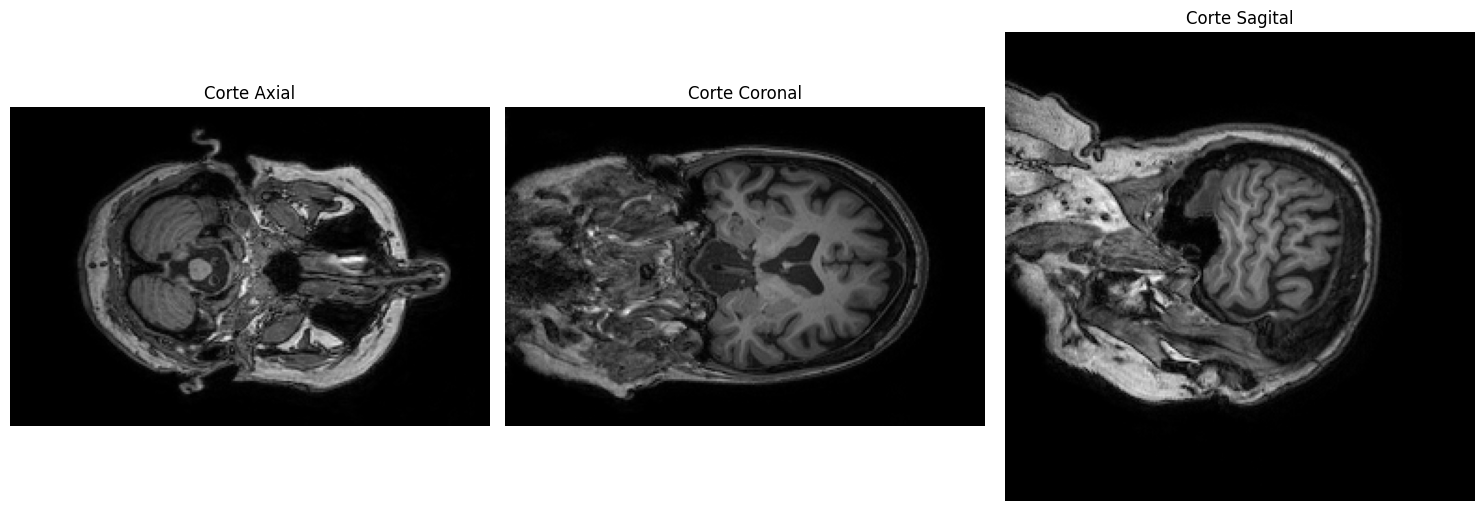

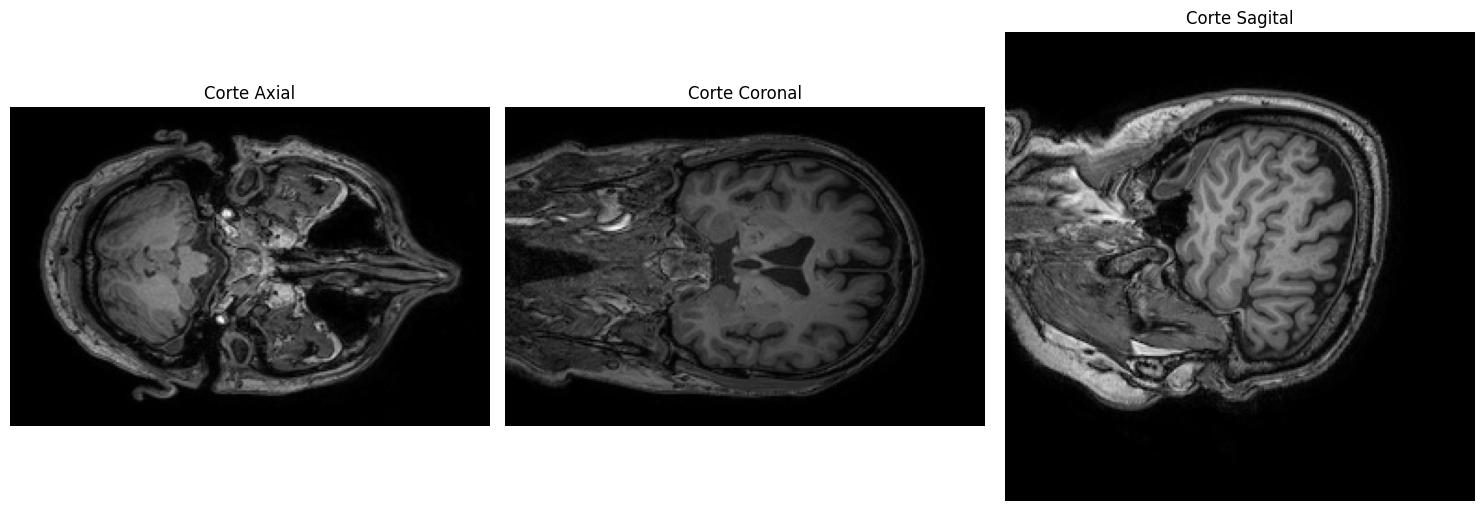

PROCESSADA COM AJUSTE MÁSCARA


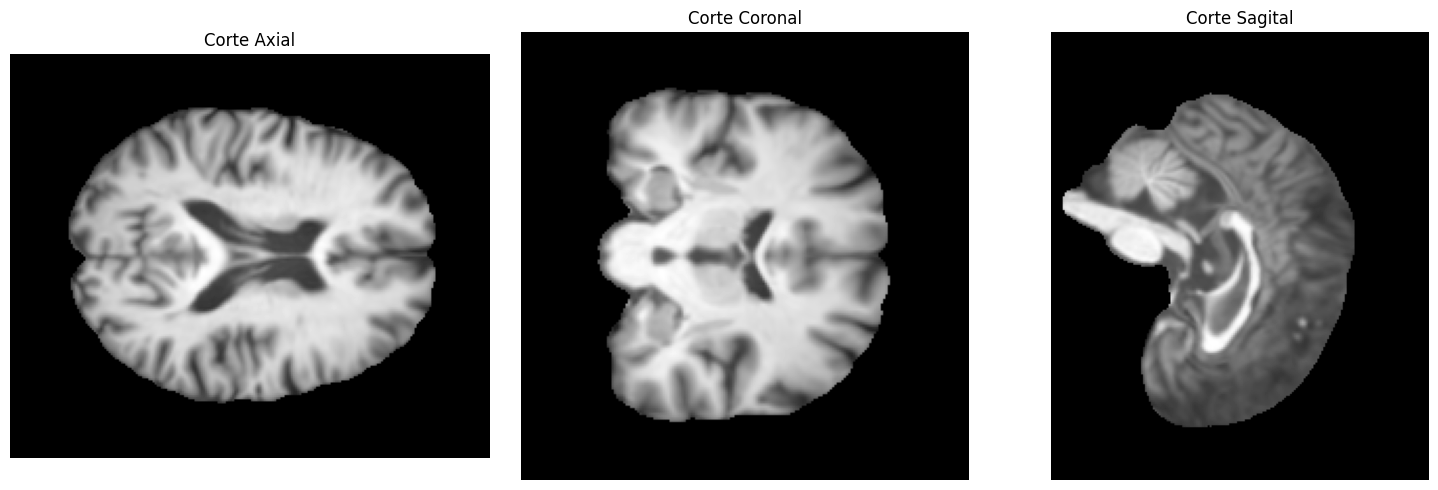

In [23]:
import ants
import os

cont = 0

#print_image(ants.image_read(os.path.join("/mnt/d/ADNI/ADNI1/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_mask.nii")))

print("ADNI2 RAW")

for item in os.listdir("/mnt/d/ADNI/ADNI2/ADNI_nii_raw"):
    if cont < 2:
        cont += 1
        print_image(ants.image_read(os.path.join("/mnt/d/ADNI/ADNI2/ADNI_nii_raw", item)))

print("PROCESSADA COM AJUSTE MÁSCARA")

for item in os.listdir("/mnt/d/ADNI/ADNI2/ADNI_nii_processed"):
    if cont < 4:
        cont += 1
        print_image(ants.image_read(os.path.join("/mnt/d/ADNI/ADNI2/ADNI_nii_processed", item)))



In [39]:
import pandas as pd

# Carregar o arquivo CSV ADNI1
adni1_csv = '/mnt/c/Users/bruno/Desktop/IANS/alzheimer_project/codes/mri/ADNI1_Screening_10_04_2024.csv' 
adni1_df = pd.read_csv(adni1_csv)

# Carregar o arquivo CSV ADNI2
adni2_csv = '/mnt/c/Users/bruno/Desktop/IANS/alzheimer_project/codes/mri/ADNI_2_Screening_-_New_Pt_10_23_2024.csv'
adni2_df = pd.read_csv(adni2_csv)

adni1 = adni1_df['Subject'].tolist()
adni2 = adni2_df['Subject'].tolist()

for item in adni2:
    if item in adni1:
        print(item)

In [40]:
import os
import pandas as pd

# Diretorio
directory = os.listdir('/mnt/d/ADNI/ADNI1/ADNI_nii_processed')

# Converte a coluna 'Subject' em uma lista
subjects1 = {'cn': [], 'mci': [], 'ad': []}

for item in directory:
    name = item.rsplit('.', 2)[0]
    line = adni1_df[adni1_df['Subject'] == name]

    group = line['Group'].iloc[0]
    
    if group == 'CN':
        subjects1['cn'].append(name)
    elif group == 'MCI':
        subjects1['mci'].append(name)
    elif group == 'AD':
        subjects1['ad'].append(name)

# Conta as ocorrências dos arquivos na lista dir
print(subjects1['cn'])
print(subjects1['mci'])
print(subjects1['ad'])

print(len(subjects1['cn']))
print(len(subjects1['mci']))
print(len(subjects1['ad']))



['002_S_0295', '002_S_0413', '002_S_0559', '002_S_0685', '002_S_1261', '002_S_1280', '005_S_0223', '005_S_0602', '006_S_0484', '006_S_0498', '006_S_0731', '007_S_0068', '007_S_0070', '007_S_1206', '007_S_1222', '014_S_0519', '014_S_0520', '014_S_0548', '014_S_0558', '021_S_0159', '021_S_0337', '021_S_0647', '021_S_0984', '024_S_0985', '024_S_1063', '027_S_0074', '027_S_0118', '027_S_0120', '027_S_0403', '029_S_0824', '029_S_0843', '029_S_0845', '031_S_0618', '033_S_0516', '033_S_0734', '033_S_0741', '033_S_0920', '033_S_0923', '033_S_1086', '037_S_0303', '037_S_0327', '037_S_0454', '037_S_0467', '052_S_0951', '052_S_1250', '052_S_1251', '094_S_0489', '094_S_0526', '094_S_0692', '094_S_0711', '094_S_1241', '094_S_1267', '098_S_0171', '098_S_0172', '098_S_0896', '116_S_0360', '116_S_0382', '116_S_0648', '116_S_0657', '116_S_1232', '116_S_1249', '127_S_0259', '127_S_0260', '127_S_0622', '127_S_0684', '128_S_0229', '128_S_0230', '128_S_0245', '128_S_0272', '128_S_0500', '128_S_0522', '128_

In [41]:
import pandas as pd

# Converte a coluna 'Subject' em uma lista
subjects2 = {'cn': [], 'mci': [], 'ad': []}

for item in adni2:
    line = adni2_df[adni2_df['Subject'] == item]

    group = line['Group'].iloc[0]
    
    if group == 'CN':
        subjects2['cn'].append(item)
    elif group == 'MCI':
        subjects2['mci'].append(item)
    elif group == 'AD':
        subjects2['ad'].append(item)

# Conta as ocorrências dos arquivos na lista dir
print(subjects2['cn'])
print(subjects2['mci'])
print(subjects2['ad'])

print(len(subjects2['cn']))
print(len(subjects2['mci']))
print(len(subjects2['ad']))

['010_S_4345', '014_S_4576', '011_S_4120', '009_S_4337', '022_S_4291', '073_S_5023', '032_S_4429', '037_S_4308', '041_S_4041', '136_S_4726', '116_S_4092', '070_S_4856', '024_S_4158', '022_S_4173', '018_S_4257', '073_S_4393', '018_S_4399', '031_S_4474', '031_S_4496', '100_S_4511', '137_S_4587', '011_S_4105', '099_S_4076', '073_S_4762', '153_S_4125', '023_S_4164', '002_S_4264', '130_S_4343', '033_S_5198', '153_S_4372', '941_S_4376', '073_S_4559', '128_S_4609', '116_S_4043', '073_S_4795', '099_S_4086', '153_S_4151', '032_S_4304', '018_S_4313', '041_S_4427', '010_S_4442', '012_S_4545', '041_S_4014', '941_S_4066', '073_S_4382', '073_S_5167', '035_S_4464', '013_S_4579', '041_S_4037', '099_S_4104', '036_S_4878', '033_S_4179', '082_S_4224', '135_S_4598', '941_S_4376', '018_S_4400', '073_S_4552', '013_S_4616', '082_S_4090', '019_S_4835', '011_S_4278', '100_S_5091', '032_S_4348', '036_S_4389', '136_S_4433', '006_S_4485', '135_S_4566', '012_S_4642', '073_S_4739', '012_S_4026', '941_S_4365', '100_

In [55]:
import pandas as pd

# Converte a coluna 'Subject' em uma lista
subjects_total = {'cn': [], 'mci': [], 'ad': []}

for item in directory:
    name = item.rsplit('.', 2)[0]
    line = adni1_df[adni1_df['Subject'] == name]

    group = line['Group'].iloc[0]
    
    if group == 'CN':
        subjects_total['cn'].append(name)
    elif group == 'MCI':
        subjects_total['mci'].append(name)
    elif group == 'AD':
        subjects_total['ad'].append(name)

for item in adni2:
    line = adni2_df[adni2_df['Subject'] == item]

    group = line['Group'].iloc[0]
    
    if group == 'CN':
        subjects_total['cn'].append(item)
    elif group == 'MCI':
        subjects_total['mci'].append(item)
    elif group == 'AD':
        subjects_total['ad'].append(item)


# Conta as ocorrências dos arquivos na lista dir
print(subjects_total['cn'])
print(subjects_total['mci'])
print(subjects_total['ad'])

print(len(subjects_total['cn']))
print(len(subjects_total['mci']))
print(len(subjects_total['ad']))

backup = subjects_total.copy()

['002_S_0295', '002_S_0413', '002_S_0559', '002_S_0685', '002_S_1261', '002_S_1280', '005_S_0223', '005_S_0602', '006_S_0484', '006_S_0498', '006_S_0731', '007_S_0068', '007_S_0070', '007_S_1206', '007_S_1222', '014_S_0519', '014_S_0520', '014_S_0548', '014_S_0558', '021_S_0159', '021_S_0337', '021_S_0647', '021_S_0984', '024_S_0985', '024_S_1063', '027_S_0074', '027_S_0118', '027_S_0120', '027_S_0403', '029_S_0824', '029_S_0843', '029_S_0845', '031_S_0618', '033_S_0516', '033_S_0734', '033_S_0741', '033_S_0920', '033_S_0923', '033_S_1086', '037_S_0303', '037_S_0327', '037_S_0454', '037_S_0467', '052_S_0951', '052_S_1250', '052_S_1251', '094_S_0489', '094_S_0526', '094_S_0692', '094_S_0711', '094_S_1241', '094_S_1267', '098_S_0171', '098_S_0172', '098_S_0896', '116_S_0360', '116_S_0382', '116_S_0648', '116_S_0657', '116_S_1232', '116_S_1249', '127_S_0259', '127_S_0260', '127_S_0622', '127_S_0684', '128_S_0229', '128_S_0230', '128_S_0245', '128_S_0272', '128_S_0500', '128_S_0522', '128_

In [49]:
import random

#dividir pastas

def distributor(subjects, new_dir, percentage):
    # Distribuindo CN
    for i in range(int(percentage * len(subjects['cn']))):
        id = random.choice(subjects['cn'])
        new_dir['cn'].append(id)
        subjects['cn'].remove(id)

    # Distribuindo MCI
    for i in range(int(percentage * len(subjects['mci']))):
        id = random.choice(subjects['mci'])
        new_dir['mci'].append(id)
        subjects['mci'].remove(id)

    # Distribuindo AD
    for i in range(int(percentage * len(subjects['ad']))):
        id = random.choice(subjects['ad'])
        new_dir['ad'].append(id)
        subjects['ad'].remove(id)

#treino (70)
train = {'cn': [], 'mci': [], 'ad': []}

distributor(subjects_total, train, 0.7)   

#validação (20)
validation = {'cn': [], 'mci': [], 'ad': []}

distributor(subjects_total, validation, 0.2)   

#teste (10)
test = {'cn': [], 'mci': [], 'ad': []}

distributor(subjects_total, test, 0.1)   

In [57]:
import random
import math

# Dividir pastas com arredondamento
def precise_distributor(subjects, new_dir, percentages):
    # Inicializando o número total de sujeitos em cada categoria
    total_cn = len(subjects['cn'])
    total_mci = len(subjects['mci'])
    total_ad = len(subjects['ad'])

    # Calculando a quantidade exata para cada conjunto, para cada categoria
    train_cn = math.floor(percentages[0] * total_cn)
    validation_cn = math.floor(percentages[1] * total_cn)
    test_cn = total_cn - train_cn - validation_cn

    train_mci = math.floor(percentages[0] * total_mci)
    validation_mci = math.floor(percentages[1] * total_mci)
    test_mci = total_mci - train_mci - validation_mci

    train_ad = math.floor(percentages[0] * total_ad)
    validation_ad = math.floor(percentages[1] * total_ad)
    test_ad = total_ad - train_ad - validation_ad

    # Distribuindo CN
    for _ in range(train_cn):
        id = random.choice(subjects['cn'])
        new_dir['train']['cn'].append(id)
        subjects['cn'].remove(id)

    for _ in range(validation_cn):
        id = random.choice(subjects['cn'])
        new_dir['validation']['cn'].append(id)
        subjects['cn'].remove(id)

    for _ in range(test_cn):
        id = random.choice(subjects['cn'])
        new_dir['test']['cn'].append(id)
        subjects['cn'].remove(id)

    # Distribuindo MCI
    for _ in range(train_mci):
        id = random.choice(subjects['mci'])
        new_dir['train']['mci'].append(id)
        subjects['mci'].remove(id)

    for _ in range(validation_mci):
        id = random.choice(subjects['mci'])
        new_dir['validation']['mci'].append(id)
        subjects['mci'].remove(id)

    for _ in range(test_mci):
        id = random.choice(subjects['mci'])
        new_dir['test']['mci'].append(id)
        subjects['mci'].remove(id)

    # Distribuindo AD
    for _ in range(train_ad):
        id = random.choice(subjects['ad'])
        new_dir['train']['ad'].append(id)
        subjects['ad'].remove(id)

    for _ in range(validation_ad):
        id = random.choice(subjects['ad'])
        new_dir['validation']['ad'].append(id)
        subjects['ad'].remove(id)

    for _ in range(test_ad):
        id = random.choice(subjects['ad'])
        new_dir['test']['ad'].append(id)
        subjects['ad'].remove(id)

# Inicializando pastas de treino, validação e teste
data_split = {
    'train': {'cn': [], 'mci': [], 'ad': []},
    'validation': {'cn': [], 'mci': [], 'ad': []},
    'test': {'cn': [], 'mci': [], 'ad': []}
}

# Proporções desejadas: 70% treino, 20% validação, 10% teste
proportions = [0.7, 0.2, 0.1]

# Distribuir os sujeitos
precise_distributor(subjects_total, data_split, proportions)

# Verificando resultados
print("Treino CN:", len(data_split['train']['cn']), "MCI:", len(data_split['train']['mci']), "AD:", len(data_split['train']['ad']))
print("Validação CN:", len(data_split['validation']['cn']), "MCI:", len(data_split['validation']['mci']), "AD:", len(data_split['validation']['ad']))
print("Teste CN:", len(data_split['test']['cn']), "MCI:", len(data_split['test']['mci']), "AD:", len(data_split['test']['ad']))


Treino CN: 172 MCI: 135 AD: 132
Validação CN: 49 MCI: 38 AD: 37
Teste CN: 25 MCI: 20 AD: 20


In [58]:
#INFORMAÇÕES

train = data_split['train']
validation = data_split['validation']
test = data_split['test']

print("BACKUP:")
print(f"CN: {len(backup['cn'])}   MCI: {len(backup['mci'])}   AD: {len(backup['ad'])}")
print(f"{backup['cn']}\n{backup['mci']}\n{subjects_total['ad']}\n\n")

print("FULL DATASET:")
print(f"CN: {len(subjects_total['cn'])}   MCI: {len(subjects_total['mci'])}   AD: {len(subjects_total['ad'])}")
print(f"{subjects_total['cn']}\n{subjects_total['mci']}\n{subjects_total['ad']}\n\n")

print("TRAIN DATASET:")
print(f"CN: {len(train['cn'])}   MCI: {len(train['mci'])}   AD: {len(train['ad'])}")
print(f"{train['cn']}\n{train['mci']}\n{train['ad']}\n\n")

print("VALIDATION DATASET:")
print(f"CN: {len(validation['cn'])}   MCI: {len(validation['mci'])}   AD: {len(validation['ad'])}")
print(f"{validation['cn']}\n{validation['mci']}\n{validation['ad']}\n\n")

print("TEST DATASET")
print(f"CN: {len(test['cn'])}   MCI: {len(test['mci'])}   AD: {len(test['ad'])}")
print(f"{test['cn']}\n{test['mci']}\n{test['ad']}\n\n")

BACKUP:
CN: 0   MCI: 0   AD: 0
[]
[]
[]


FULL DATASET:
CN: 0   MCI: 0   AD: 0
[]
[]
[]


TRAIN DATASET:
CN: 172   MCI: 135   AD: 132
['037_S_4071', '006_S_4150', '082_S_4339', '099_S_4104', '136_S_0196', '011_S_4105', '022_S_4320', '136_S_4269', '011_S_4222', '073_S_4559', '041_S_4037', '029_S_0843', '021_S_0647', '041_S_5100', '116_S_0360', '014_S_4093', '941_S_4376', '010_S_4345', '014_S_4401', '073_S_4795', '100_S_5091', '012_S_4643', '002_S_4262', '136_S_0086', '022_S_4291', '018_S_4399', '033_S_0920', '014_S_4577', '036_S_4389', '052_S_1250', '094_S_0489', '137_S_4587', '031_S_4496', '014_S_4080', '037_S_0303', '041_S_4060', '128_S_0500', '019_S_4367', '006_S_4357', '031_S_4218', '100_S_5075', '128_S_0272', '010_S_4442', '116_S_4010', '023_S_4448', '094_S_1241', '137_S_4466', '021_S_0159', '153_S_4372', '153_S_4151', '137_S_0686', '082_S_4224', '023_S_4020', '027_S_0074', '133_S_0433', '082_S_4428', '021_S_0337', '024_S_4084', '135_S_4598', '094_S_1267', '032_S_4304', '131_S_0436